In [1]:
# basic libraries and functions
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#
import pickle
#
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
#
#
SAVE = lambda data, dir, name: pickle.dump(data, open(dir + name + ".pkl", "wb"))   # save file
LOAD = lambda file:            pickle.load(open(file + ".pkl", "rb"))               # read file

In [2]:
# read if file exists
def TRY_LOAD(file):
    try:
        data = LOAD(file)
        return data
    except:
        return 0
        #
    #####
    #
#####

In [3]:
# basic paths
ORIGIN = "original_features"                                         # original features
DER_1  = "der_features_hypothesis_1"                                 # derived features: ver. 1
DER_2  = "der_features_hypothesis_2"                                 # derived features: ver. 2
#
correlations_dir = "b_correlations/"                                 # directory of "find_correlations" outputs
fitted_model_all = "a_fitted_model/all_dataset/"                     # directory of "RandomForestClassifier" outputs (using all dataset)
fitted_model_par = "a_fitted_model/partial_dataset/"                 # directory of "RandomForestClassifier" outputs (with partial dataset)
gini_impurities  = "c_gini_impurities/"                              # directory of "Feature_Importances" outputes (1/10 of dataset)
#
#
fitted_all_original_features  = TRY_LOAD(fitted_model_all + ORIGIN)  # random forest weights (for all original dataset)
fitted_all_der_features_hyp_1 = TRY_LOAD(fitted_model_all + DER_1)   # random forest weights (for all der. ver. 1 dataset)
fitted_all_der_features_hyp_2 = TRY_LOAD(fitted_model_all + DER_2)   # random forest weights (for all der. ver. 2 dataset)
#
#
original_features_correlation = TRY_LOAD(correlations_dir + ORIGIN)  # correlation study (for all original dataset)
derived_features_correlation  = TRY_LOAD(correlations_dir + DER_1)   # correlation study (for all der. ver. 1 dataset)
#
#
gini_impurities_of_original   = TRY_LOAD(gini_impurities + ORIGIN)   # gini impurities among original features
#                                                                    # (average among many realizations of 1/10 of dataset)
gini_impurities_of_derived_1  = TRY_LOAD(gini_impurities + DER_1)    # gini impurities among derived features (same)

In [4]:
# reading original features
def make_df(dir, file):
    df     = pd.DataFrame()
    df_tmp = pd.read_csv("data/" + dir + "/" + file, delimiter = " ", skiprows = 2)
    #
    df["ALPHA"] = 0                                # associated with the efficiency of common envelope
    df["METAL"] = 0                                # stellar metallicity at which the black holes where produced
    df["MST1"]  = df_tmp["col.1:m1ZAMS/Msun"]      # ZAMS mass of the primary member of the binary system (BS) [Msun]
    df["MST2"]  = df_tmp["col.2:m2ZAMS/Msun"]      # ZAMS mass of the secondary member of the BS [Msun]
    df["MBH1"]  = df_tmp["col.3:m1rem/Msun"]       # mass of the black hole (BH) from the primary member [Msun]
    df["MBH2"]  = df_tmp["col.4:m2rem/Msun"]       # mass of the BH from the secondary member [Msun]
    df["TIME"]  = df_tmp["col.6:delay_time/Myr"]   # time from the formation of the BS to the merger of the two BH [Myr]
    df["AXIS"]  = df_tmp["col.7:sma/Rsun"]         # semi-major axis of the BS at the formation of the second-born BH [Rsun] 
    df["ECCE"]  = df_tmp["col.8:ecc"]              # orbital eccentricity of the BS at the formation of the second-born BH
    df["ISCE"]  = df_tmp["col.21:CE"]              # True: the BS undergoes a common envelope. False: the BS goes via stable mass transfer
    df["ALPHA"] = np.float64(dir[1:])
    df["METAL"] = np.float64(file.split("_")[-1].split(".txt")[0])
    del df_tmp
    return df
    #
#####

In [5]:
# making derived features [HYPOTHESIS 1]
def make_der_df(df):
    df_der = pd.DataFrame()
    df_der["ALPHA"]           = df["ALPHA"]
    df_der["METAL"]           = df["METAL"]
    df_der["MS_TOT"]          = df["MST2"] + df["MST1"]                                # MST2+MST1
    df_der["MS_RATIO"]        = df["MST2"] / df["MST1"]                                # MST2/MST1
    df_der["M_LOSS"]          = 1 - ((df["MBH2"] + df["MBH1"]) / df_der["MS_TOT"])     # 1-[(MBH2+MBH1)/(MST2+MST1)]
    df_der["M_RATIO_LOSS"]    = 1 - ((df["MBH2"] / df["MBH1"]) / df_der["MS_RATIO"])   # 1-[(MBH2/MBH1)/(MST2/MST1)]
    df_der["INITIAL_DENSITY"] = df_der["MS_TOT"] / (df["AXIS"] ** 2)                   # (MST2+MST1)/(AXIS^2)
    df_der["ISCE"]            = df["ISCE"]
    return df_der
    #
#####

In [6]:
def making_plot(columns, values, title, xlabel, ylabel):
    plt.figure(figsize = (10, 6))
    plt.bar(columns, values, color = 'skyblue')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation = 45)
    plt.show()
    #
#####

In [7]:
# reading original features
df = [make_df(dir, file) for dir in os.listdir("data") for file in os.listdir("data/" + dir)]
df = pd.concat(df, ignore_index = True)
#
# making derived features
df_der = make_der_df(df)
#
#
# columns
# [ORIGINAL FEATURES]
original_columns   = ["ALPHA", "METAL", "MST1", "MST2", "MBH1", "MBH2", "TIME", "AXIS", "ECCE"]
#
# [DERIVED FEATURES - HYPOTHESIS 1]
der_hypo_1_columns = df_der.columns[:-1]
#
# [DERIVED FEATURES - HYPOTHESIS 2]
der_hypo_2_columns = ["ALPHA",             # as hyp 1
                      "METAL",             # as hyp 1
                      "MS_TOT",            # as hyp 1
                      "MS_RATIO",          # as hyp 1
                      "MS_RATIO_INV",      # MS_RATIO ** (-1)
                      "MBH_RATIO",         # MBH2 / MBH1
                      "M_LOSS",            # as hyp 1
                      "M_RATIO_LOSS",      # as hyp 1
                      "INITIAL_DENSITY"]   # as hyp 1
#
#
# original features
x0 = df[original_columns]
y0 = df["ISCE"]
#
# derived features
x1 = df_der[der_hypo_1_columns]
y1 = df_der["ISCE"]

In [8]:
x0

,ALPHA,METAL,MST1,MST2,MBH1,MBH2,TIME,AXIS,ECCE
0,0.5,0.0002,24.1323,17.1893,9.5692,5.0020,141.1783,5.1703,0.258940
1,0.5,0.0002,69.5474,64.3689,28.4847,39.1186,9.2023,6.4328,0.055966
2,0.5,0.0002,106.6977,41.0318,39.9392,38.2094,2223.2639,35.8880,0.041435
3,0.5,0.0002,74.3594,54.3256,30.1523,37.4020,8.7628,6.0720,0.041342
4,0.5,0.0002,116.6000,63.2642,41.9604,42.9817,2636.2197,40.0410,0.079504
...,...,...,...,...,...,...,...,...,...
2963577,5.0,0.0200,49.5343,41.7016,4.9807,4.6760,10772.9297,11.8280,0.251980
2963578,5.0,0.0200,89.2801,62.1861,7.3304,5.1195,16.0614,462.4200,0.999370
2963579,5.0,0.0200,36.4361,27.1551,4.0565,3.2400,2200.2712,212.1500,0.993170
2963580,5.0,0.0200,73.1220,37.7591,8.2607,4.8831,6547.9141,302.6300,0.988970


# Test

In [9]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import time

In [10]:
#data_df = df.filter(['ALPHA','METAL','MST1', 'MST2', 'MBH1', 'MBH2','TIME','AXIS','ECCE'], axis=1)

#target_df = df.filter(['ISCE'], axis=1)

In [11]:
#X = data_df
#y = target_df 

#x0, y0, x1, y1 = reading_all_datasets()

X = x0
y = y0
# Splitting arrays or matrices into random train and test subsets

# i.e. 70 % training dataset and 30 % test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)

In [12]:
#making_plot(X.columns, importances, "Feature Importance Based on Recursive Feature Elimination (RFE)", "Features", "Importance")

def draw_plot(columns, values, title, xlabel, ylabel, log):
    plt.figure(figsize = (10, 6))
    plt.bar(columns, values, color = 'skyblue', log=log)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation = 45)
    plt.grid()
    plt.show()

-

-

-

# Lasso 

Lasso regression is a modified form of linear regression. It uses the following formula for calculation:

$$\frac{1}{2N_{training}} \sum_{i=1}^{N_{training}} \left( y_{real}^{(i)} -  y_{real}^{(i)} \right)^2 + \alpha \sum_{j=1}^{n} a_j $$

where $a_j$ is the coefficient of the j-th feature. The final term is called $l1$ penalty and $\alpha$ is a hyperparameter that tunes the intensity of this penalty term. The higher the coefficient of a feature, the higher the value of the cost function. So, the idea of Lasso regression is to optimize the cost function reducing the absolute values of the coefficients.

The $\alpha$ hyperparameter value is found using a cross-validation approach.

Trying to minimize the cost function, Lasso regression will automatically select those features that are useful, discarding the useless or redundant features. In Lasso regression, discarding a feature will make its coefficient equal to 0.

So, the idea of using Lasso regression for feature selection purposeis that,e: we fit a Lasso regression on a scaled version of our dataset and we consider only those features that have a coefficient different from 0. 

In [13]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV, KFold

In [14]:
def Lasso_test():
        # parameters to be tested on GridSearchCV
        params = {"alpha":np.arange(0.00001, 10, 500)}
        
        # finding 'alpha' using k-fold cross-validation approach
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        
        # Initializing the Model
        lasso = Lasso()
        
        # GridSearchCV with model, params and folds.
        lasso_cv=GridSearchCV(lasso, param_grid=params, cv=kf)
        lasso_cv.fit(X, y)
        #print("Best Params {}".format(lasso_cv.best_params_))

        alpha = lasso_cv.best_params_['alpha']
        
        # calling the model with the best parameter
        lasso1 = Lasso(alpha)
        #lasso1 = Lasso(alpha=0.0005)
        lasso1.fit(X_train, y_train)
        
        # Using np.abs() to make coefficients positive.  
        lasso1_coef = np.abs(lasso1.coef_)

        return lasso1_coef

In [15]:
#Calling the lasso method to get the feature importances
importances = Lasso_test()

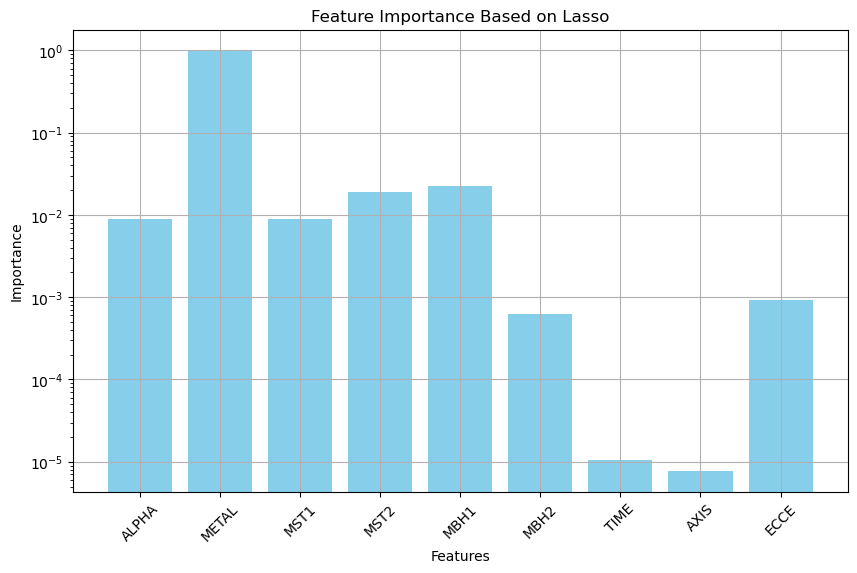

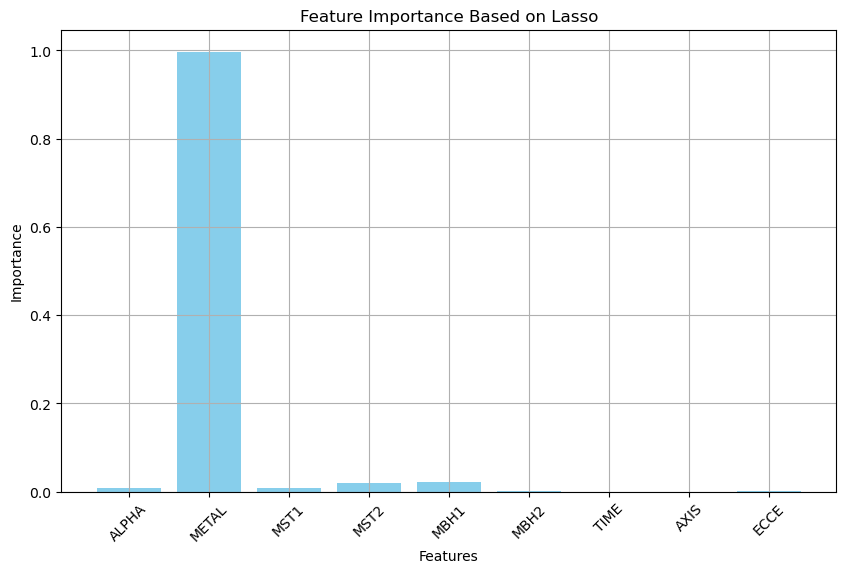

In [16]:
# plotting the Column Names and Importance of Columns.
#making_plot(X.columns, importances, "Feature Importance Based on Lasso", "Features", "Importance")
draw_plot(X.columns, importances, "Feature Importance Based on Lasso", "Features", "Importance", True) #log = true

draw_plot(X.columns, importances, "Feature Importance Based on Lasso", "Features", "Importance", False) #log = false

-

-

-

# Permutation

The idea behind permutation feature importance is that, the feature importance is calculated by noticing the increase or decrease in error when we permute the values of a feature. If permuting the values causes a huge change in the error, it means the feature is important for our model. 

The best thing about this method is that it can be applied to every machine learning model. Its approach is model agnostic, which gives you a lot of freedom. There are no complex mathematical formulas behind it. The permutation feature importance is based on an algorithm that works as follows:
<br> 1. Calculate the mean squared error with the original values.
<br> 2. Shuffle the values for that features and make predictions.
<br> 3. Calculate the mean squared error with the shuffled values.
<br> 4. Compare the differences between them.
<br> 5. Sort the differences in descending order to get features with most to least importance.

This technique measures the contribution of a feature by measuring the changes in the model performance after randomly shuffling its values. This approach is straightforward but can be computationally intensive for large datasets. 

In our code, we used a scikit-learn function where feature importance is evaluated in a predictive model by the impact on the model’s performance (here, utilizing accuracy scoring) when the values of each feature are randomly shuffled. The <i>n_repeats</i> parameter specifies the number of times each feature’s values are randomly shuffled to assess its impact on the model’s performance. In our case, each feature will be permuted 30 times, and the model’s performance will be evaluated after each permutation, hence the aggregate calculation of the mean and standard deviation of the importance values. However, selecting the value of <i>n_repeats</i> has computational consequences as higher values can highlight precise and robust importance calculations but higher computational cost.

In [17]:
from sklearn.linear_model import Ridge
from sklearn.inspection import permutation_importance

def permutation_test():
    model = Ridge(alpha=1e-2).fit(X_train, y_train)
    model.score(X_test, y_test)

    r = permutation_importance(model, X_test, y_test, n_repeats=30, random_state=0)

    return r.importances_mean

In [18]:
#Calling the permutation method to get the feature importances
importances = permutation_test()

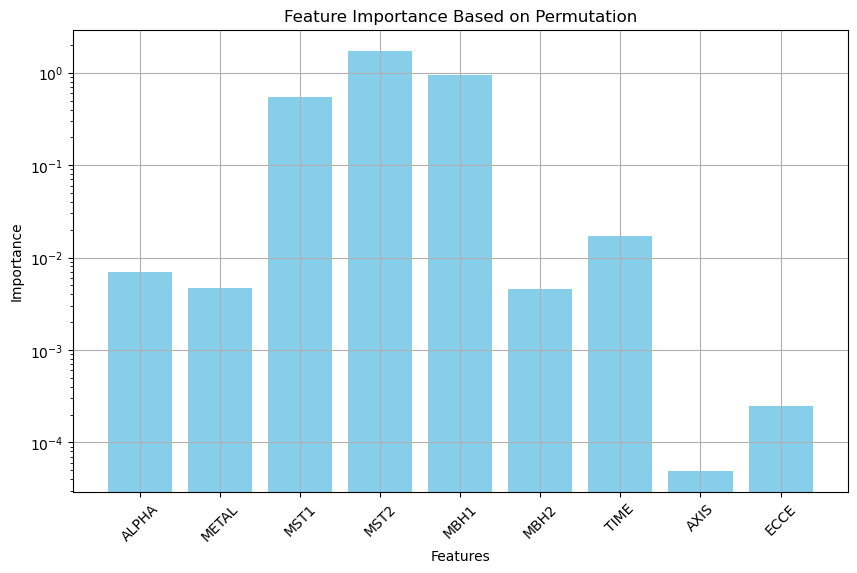

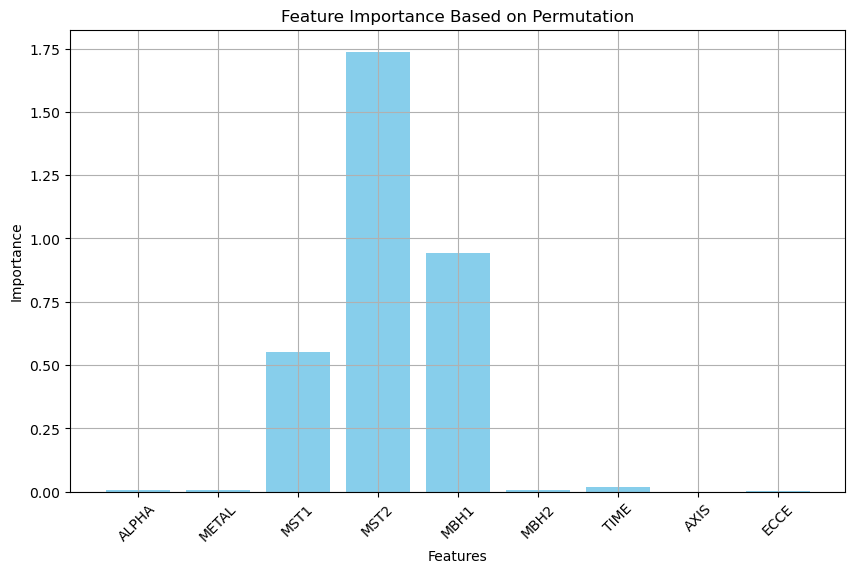

In [19]:
# plotting the Column Names and Importance of Columns.
#making_plot(X.columns, importances, "Feature Importance Based on Permutation", "Features", "Importance")
draw_plot(X.columns, importances, "Feature Importance Based on Permutation", "Features", "Importance", True) #log = true

draw_plot(X.columns, importances, "Feature Importance Based on Permutation", "Features", "Importance", False) #log = false

-

-

-

# Single-Variable Prediction

Single-variable prediction is a method of feature importance that measures the performance of a model when only one feature is used to make predictions. 

This can be done by training a model using only one feature and comparing its performance to the performance of the model when all features are used. The feature that results in the highest performance when used alone is considered the most important.

It should be noted that the importance of a feature may depend on the context in which it is used – for example, a feature that is important in isolation may not be so important when considered in combination with other features.


Single-variable prediction entails training an ML model for each individual feature to understand how well the variable is able to predict the target value. It consists of building a model with the individual features, evaluating across respective metrics, and observing how significant each feature is to predicting the target. It provides simplicity and intuitiveness, however, this method doesn’t capture the intrinsic interactions that exist between features to create a combined impact on the model.

In [20]:
from sklearn.feature_selection import SelectKBest, f_regression

def SVP_test():
    # Applying SelectKBest with ANOVA F-value
    selector = SelectKBest(score_func=f_regression, k='all')
    selector.fit(X, y)
    
    # Displaying scores for each feature
    #feature_scores = pd.DataFrame({'Feature': X.columns, 'Score': selector.scores_})
    #print(feature_scores.sort_values(by='Score', ascending=False))
    
    return selector.scores_

In [21]:
#Calling the Single-Variable Prediction method to get the feature importances
importances = SVP_test()

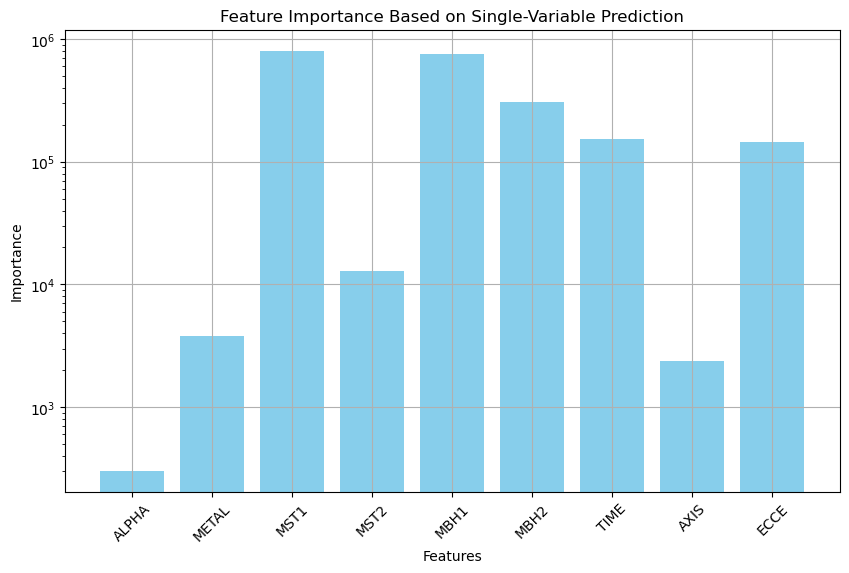

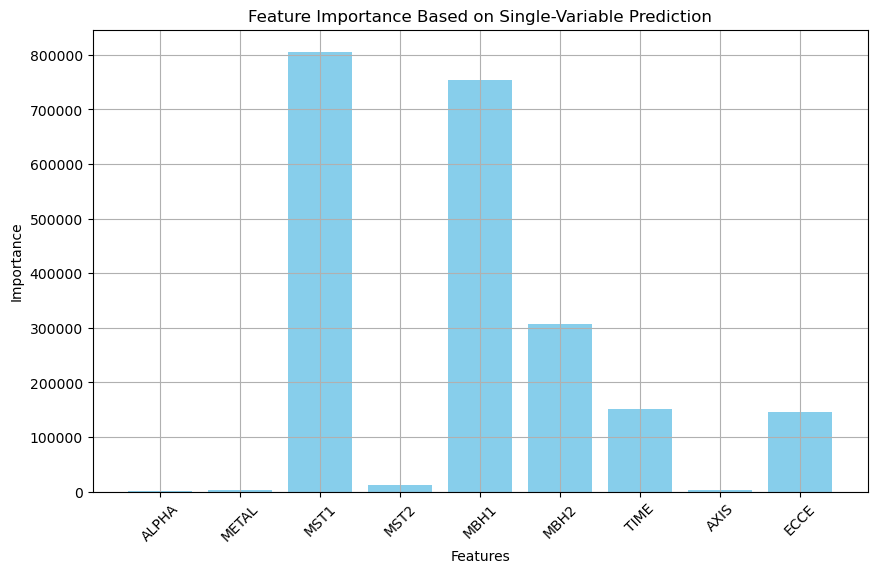

In [22]:
# plotting the Column Names and Importance of Columns.
#making_plot(X.columns, importances, "Feature Importance Based on Single-Variable Prediction", "Features", "Importance")
draw_plot(X.columns, importances, "Feature Importance Based on Single-Variable Prediction", "Features", "Importance", True) #log = true

draw_plot(X.columns, importances, "Feature Importance Based on Single-Variable Prediction", "Features", "Importance", False) #log = false

-

-

-

# Recursive Feature Elimination (RFE)

RFE is a feature selection method that iteratively evaluates the importance of features and removes the least important ones until the desired number remains. It uses the model’s internal feature importance measures to guide the elimination process.
<br> 1. Train the model on the full dataset.
<br> 2. Rank features based on their importance scores.
<br> 3. Remove the least important feature(s) and retrain the model.
<br> 4. Repeat until a stopping criterion is met, such as reaching a desired number of features or observing a performance drop.hange. drop.

In [27]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

def RFE_test():
    # Initialize the model (LinearRegression here, but you can use others)
    model = LinearRegression()
    
    # Applying RFE
    rfe = RFE(estimator=model, n_features_to_select=5)  # Change n_features_to_select as needed
    rfe.fit(X, y)
    
    # Displaying ranking of features
    #feature_ranking = pd.DataFrame({'Feature': X.columns, 'Ranking': rfe.ranking_})
    #print(feature_ranking.sort_values(by='Ranking'))
    
    return rfe.ranking_

In [28]:
#Calling the permutation method to get the feature importances
importances = RFE_test()

In [30]:
importances

array([1, 1, 2, 1, 1, 3, 4, 5, 1])

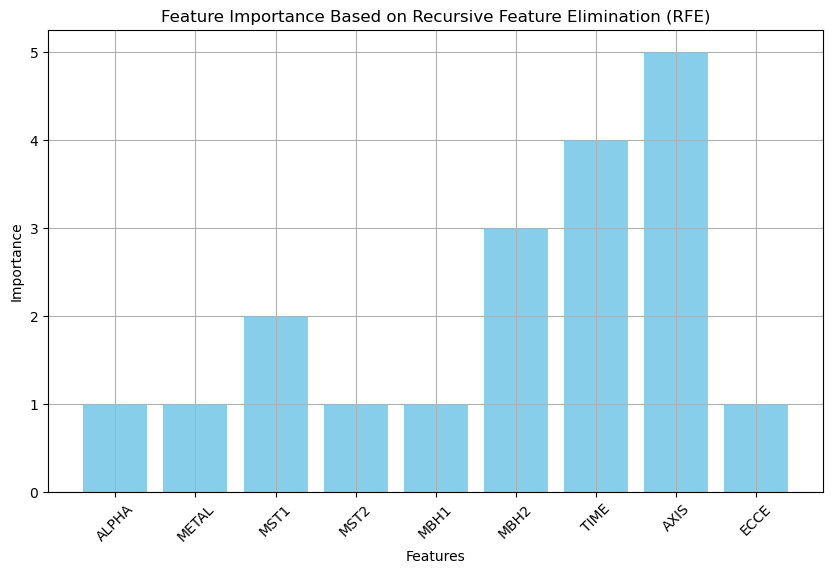

In [31]:
# plotting the Column Names and Importance of Columns.
#making_plot(X.columns, importances, "Feature Importance Based on Recursive Feature Elimination (RFE)", "Features", "Importance")
#draw_plot(X.columns, importances, "Feature Importance Based on Recursive Feature Elimination (RFE)", "Features", "Importance", True) #log = true

draw_plot(X.columns, importances, "Feature Importance Based on Recursive Feature Elimination (RFE)", "Features", "Importance", False) #log = false

-

-

-

# Principal Component Analysis(PCA)

PCA is a dimensionality reduction that identifies important relationships in our data, transforms the existing data based on these relationships, and then quantifies the importance of these relationships so we can keep the most important relationships and drop the others. To remember this definition, we can break it down into four steps:
<br>1. We identify the relationship among features through a Covariance Matrix.
<br>2. Through the linear transformation or eigendecomposition of the Covariance Matrix, we get eigenvectors and eigenvalues.
<br>3. Then we transform our data using Eigenvectors into principal components.
<br>4. Lastly, we quantify the importance of these relationships using Eigenvalues and keep the important principal components.

In [32]:
from sklearn.decomposition import PCA

def PCA_test():
    # Applying PCA
    pca = PCA(n_components=2)  # Adjust n_components as needed
    principal_components = pca.fit_transform(X)
    
    # Displaying explained variance ratio of each component
    #explained_variance = pd.DataFrame({'Component': range(1, pca.n_components_ + 1), 'Explained Variance': pca.explained_variance_ratio_})
    #print(explained_variance)

    component_weights = pca.components_
    #print("Component Weights:\n", component_weights)
    
    feature_weights_mapping = {}
    for i, component in enumerate(component_weights):
        component_feature_weights = zip(X.columns, component)
        feature_weights_mapping[f"Component {i+1}"] = component_feature_weights
        #sorted(component_feature_weights, key=lambda x: abs(x[1]), reverse=True)
    
    # Accessing feature names contributing to Component 1
    #print("Feature names contributing to Component 1:")
    feat1 = []
    wght1 = []
    for feature, weight in feature_weights_mapping["Component 1"]:
        feat1.append(feature)
        wght1.append(weight)
        #print(f"{feature}: {weight}")
    
    # Accessing feature names contributing to Component 2
    #print("Feature names contributing to Component 2:")
    feat2 = []
    wght2 = []
    for feature, weight in feature_weights_mapping["Component 2"]:
        feat2.append(feature)
        wght2.append(weight)
        #print(f"{feature}: {weight}")

    return feat1, wght1, feat2, wght2

In [33]:
#Calling the PCA method to get the features(as f1 and f2) and their corresponding importances(as weights w1 and w2)
# along the first and second principle componants (PCA1 & PCA2)

f1, w1, f2, w2 = PCA_test()

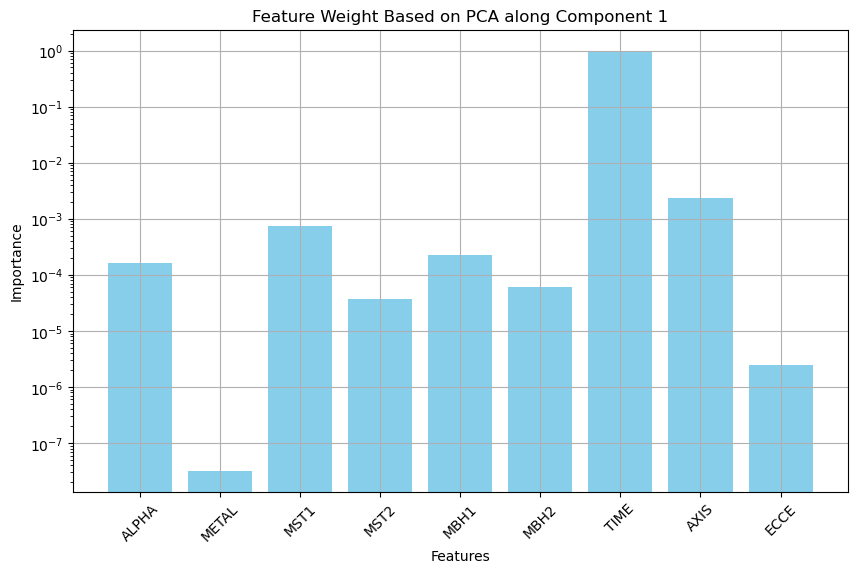

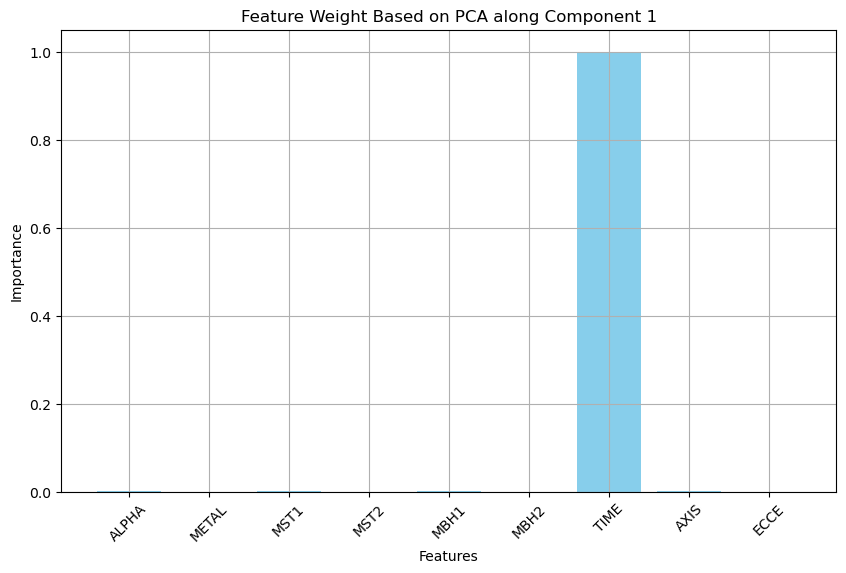

In [34]:
# plotting the Column Names and Importance of Columns.

#making_plot(f1, w1, "Feature Weight Based on PCA along Component 1", "Features", "Importance")
#making_plot(f2, w2, "Feature Weight Based on PCA along Component 2", "Features", "Importance")

draw_plot(f1, w1, "Feature Weight Based on PCA along Component 1", "Features", "Importance", True) #log = true

draw_plot(f1, w1, "Feature Weight Based on PCA along Component 1", "Features", "Importance", False) #log = false

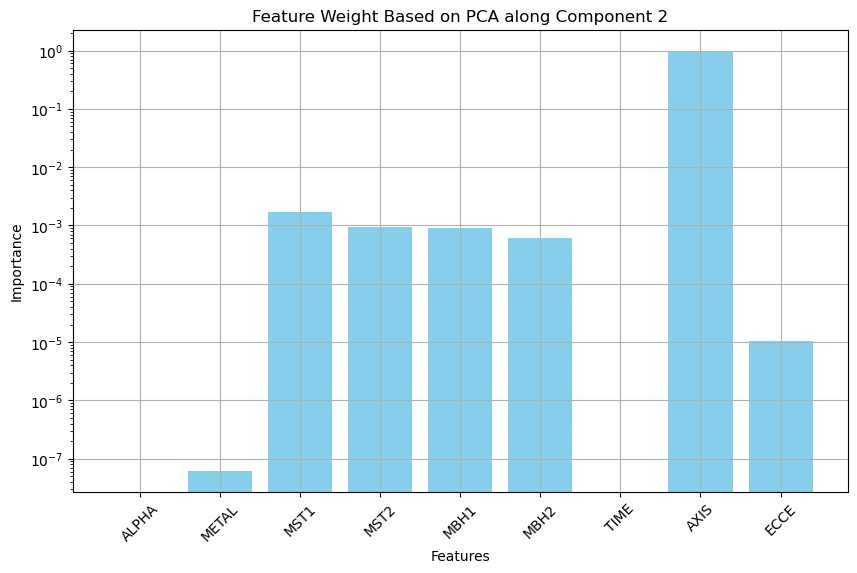

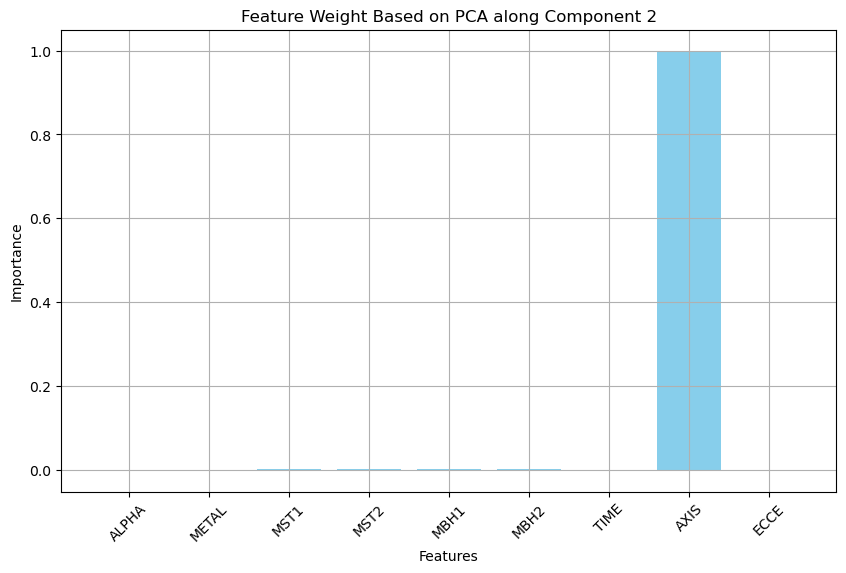

In [35]:
draw_plot(f2, w2, "Feature Weight Based on PCA along Component 2", "Features", "Importance", True) #log = true

draw_plot(f2, w2, "Feature Weight Based on PCA along Component 2", "Features", "Importance", False) #log = false

-

-

-

# gradient boosting algorithm (xgboost)

A benefit of using gradient boosting is that after the boosted trees are constructed, it is relatively straightforward to retrieve importance scores for each attribute.

Generally, importance provides a score that indicates how useful or valuable each feature was in the construction of the boosted decision trees within the model. The more an attribute is used to make key decisions with decision trees, the higher its relative importance.

This importance is calculated explicitly for each attribute in the dataset, allowing attributes to be ranked and compared to each other.

Importance is calculated for a single decision tree by the amount that each attribute split point improves the performance measure, weighted by the number of observations the node is responsible for. The performance measure may be the purity (Gini index) used to select the split points or another more specific error function.

The feature importances are then averaged across all of the the decision trees within the model.

In [ ]:
#pip install xgboost

In [36]:
from xgboost import XGBClassifier

def xgboost_test():
    model = XGBClassifier()
    model.fit(X_train, y_train)
    #importances = pd.DataFrame(data={
     #   'Attribute': X_train.columns,
      #  'Importance': model.feature_importances_
    #})
    return model.feature_importances_
    #importances = importances.sort_values(by='Importance', ascending=False)

In [37]:
#Calling the permutation method to get the feature importances
importances = xgboost_test()

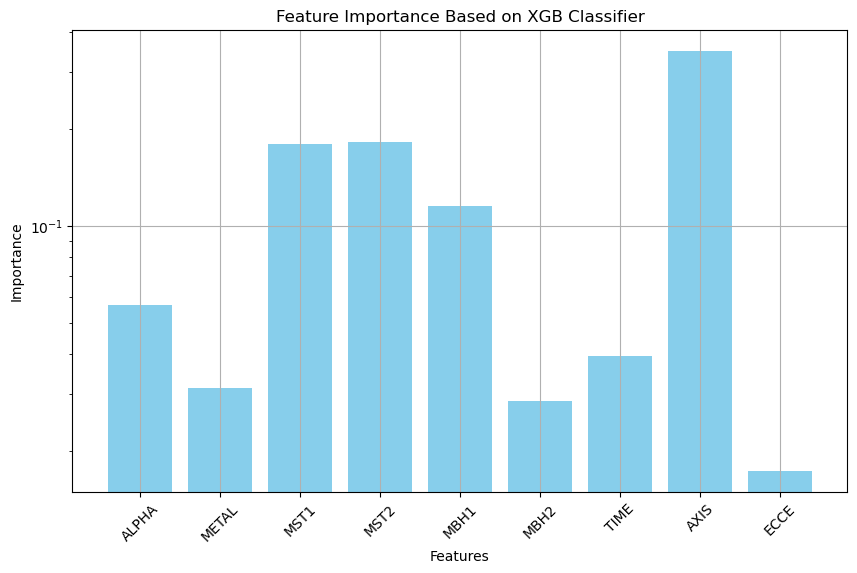

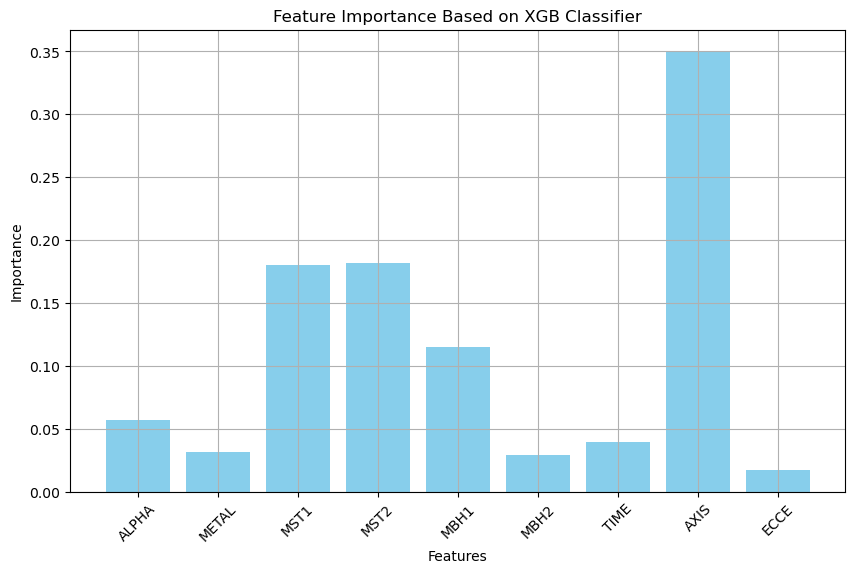

In [38]:
# plotting the Column Names and Importance of Columns.
#making_plot(X.columns, importances, "Feature Importance Based on XGB Classifier", "Features", "Importance")

draw_plot(X.columns, importances, "Feature Importance Based on XGB Classifier", "Features", "Importance", True) #log = true

draw_plot(X.columns, importances, "Feature Importance Based on XGB Classifier", "Features", "Importance", False) #log = false